# CNN model for CIFAR-10 - Object Recognition in Images

[Benchmark](https://paperswithcode.com/sota/image-classification-on-cifar-10)

Ref.

[Convolutional Neural Network (CNN) ](https://www.tensorflow.org/tutorials/images/cnn)

[Step-by-Step Guide to Build CNN Model with Tensorflow](https://www.aitude.com/step-by-step-guide-to-build-cnn-model-with-tensorflow/)

[Writing CNNs from Scratch in PyTorch](https://blog.paperspace.com/writing-cnns-from-scratch-in-pytorch/#:~:text=CNN%20from%20Scratch%201%20You%20start%20by%20creating,define%20a%20forward%20method%20in%20our%20class.%20)

[PyTorch-Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar)

This explains some knowledge.
[CIFAR 10- CNN using PyTorch](https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch)

In [21]:
import pickle
from sklearn import metrics
import numpy as np
from torchvision import datasets
from torchvision.transforms import ToTensor, v2
import keras
from keras import layers
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

## Load dataset

In [2]:
version = "final"
training = False
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 100
validation_split = 1.0 if training else 0.0
output_filename = "output-summary-{0}.txt".format(version)
feature = ["batch normalization", "dropout", "add more layers", "fit all training data with no validation split"]

In [3]:
# Using pytorch utils to load dataset
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

training_data = datasets.CIFAR10("data", train=True, download=True, transform=ToTensor())
test_data = datasets.CIFAR10("data", train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## EDA

In [4]:
class_names = training_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
train_images: np.ndarray = training_data.data
test_images: np.ndarray = test_data.data

train_labels = training_data.targets
test_labels = test_data.targets

In [6]:
def plot_cifar10_images(images, n):
    plt.figure(figsize=[10, 10])

    for i in range(n):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_labels[i]])

    plt.show()

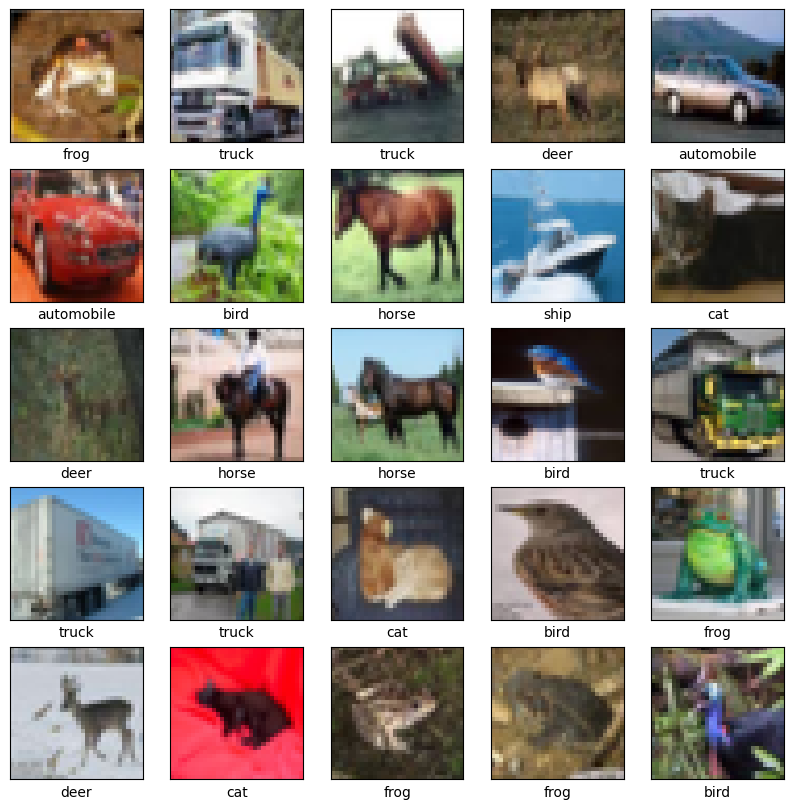

In [7]:
plot_cifar10_images(train_images, 25)

In [8]:
print("train images shape: ", train_images.shape)
print("train labels size: ", len(train_labels))
print("test images shape: ", test_images.shape)
print("test labels size: ", len(test_labels))

train images shape:  (50000, 32, 32, 3)
train labels size:  50000
test images shape:  (10000, 32, 32, 3)
test labels size:  10000


## Data preprocessing

In [9]:
# Image augmentation
# Ref. https://www.kaggle.com/code/vikasbhadoria/cifar10-high-accuracy-model-build-on-pytorch
# Ref. https://pytorch.org/vision/stable/transforms.html

# transform_train_image = v2.Compose(
#     [
#         v2.ToImage(),
#         v2.Resize((32, 32)),  # resises the image so it can be perfect for our model.
#         v2.RandomHorizontalFlip(p=0.5),  # FLips the image w.r.t horizontal axis
#         v2.RandomRotation(10),  # Rotates the image to a specified angel
#         v2.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Performs actions like zooms, change shear angles.
#         v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Set the color params
#     ]
# )

# train_images_augmentation = np.array([transform_train_image(train_images[i]) for i in range(len(train_images))])

In [10]:
# train_images_augmentation = train_images_augmentation.transpose((0, 2, 3, 1))
# train_images_augmentation.shape

In [11]:
# plot_cifar10_images(train_images_augmentation, 25)

In [12]:
# Join augmented images to train images & do normalization
# train_images = np.concatenate((train_images, train_images_augmentation)).astype("float32") / 255.0
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Append train labels due to train images augmentation & one-hot encode labels
# train_labels = keras.utils.to_categorical(train_labels + train_labels, num_classes)
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [13]:
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


## Build Convolutional Neural Networks (CNN)

Ref.

[CNN 基礎知識 —— 池化 (pooling)](https://zhuanlan.zhihu.com/p/78760534)

[卷積神經網絡介紹(Convolutional Neural Network)](https://medium.com/jameslearningnote/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC5-1%E8%AC%9B-%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E7%B5%A1%E4%BB%8B%E7%B4%B9-convolutional-neural-network-4f8249d65d4f)

![CNN concept](./images/cnn.png)

Code ref.

僅參考，因為程式碼需要調整
[Step-by-Step Guide to Build CNN Model with Tensorflow](https://www.aitude.com/step-by-step-guide-to-build-cnn-model-with-tensorflow/)

非常有幫助
[Simple Cifar10 CNN Keras code with 88% Accuracy](https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy)

In [14]:
# Build a custom CNN model using keras.Model subclassing


@keras.saving.register_keras_serializable(package="CIFAR10_CNN_Layer")
class CNN(keras.Model):

    def __init__(self, **kwargs):

        super(CNN, self).__init__()

        # Batch normalization (BN): https://medium.com/ching-i/batch-normalization-%E4%BB%8B%E7%B4%B9-135a24928f12
        # 對每一個 mini-batch 都進行正規化到平均值為0、標準差為1的常態分佈
        # * 減緩梯度消失
        # * 解決 Internal Covariate Shift (ICS) 的問題

        self.cnn_layer_1 = layers.Conv2D(32, (3, 3), padding="same", activation="relu")
        self.batch_normalization_1 = layers.BatchNormalization()

        self.cnn_layer_2 = layers.Conv2D(32, (3, 3), padding="same", activation="relu")
        self.batch_normalization_2 = layers.BatchNormalization()

        self.pooling_1 = layers.MaxPooling2D((2, 2))
        self.dropout_1 = layers.Dropout(0.3)

        self.cnn_layer_3 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")
        self.batch_normalization_3 = layers.BatchNormalization()

        self.cnn_layer_4 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")
        self.batch_normalization_4 = layers.BatchNormalization()

        self.pooling_2 = layers.MaxPooling2D((2, 2))
        self.dropout_2 = layers.Dropout(0.5)

        self.cnn_layer_5 = layers.Conv2D(128, (3, 3), padding="same", activation="relu")
        self.batch_normalization_5 = layers.BatchNormalization()

        self.cnn_layer_6 = layers.Conv2D(128, (3, 3), padding="same", activation="relu")
        self.batch_normalization_6 = layers.BatchNormalization()

        self.pooling_3 = layers.MaxPooling2D((2, 2))
        self.dropout_3 = layers.Dropout(0.5)

        self.flatten = layers.Flatten()

        self.first_dense_layer = layers.Dense(64, activation="relu")

        self.dense_batch_normalization = layers.BatchNormalization()
        self.dense_dropout = layers.Dropout(0.5)

        self.second_dense_layer = layers.Dense(10, activation="softmax")

    def call(self, inputs, training=False):

        x = self.cnn_layer_1(inputs, training=training)
        x = self.batch_normalization_1(x, training=training)

        x = self.cnn_layer_2(x, training=training)
        x = self.batch_normalization_2(x)

        x = self.pooling_1(x)
        x = self.dropout_1(x)

        x = self.cnn_layer_3(x, training=training)
        x = self.batch_normalization_3(x, training=training)

        x = self.cnn_layer_4(x, training=training)
        x = self.batch_normalization_4(x)

        x = self.pooling_2(x)
        x = self.dropout_2(x)

        x = self.cnn_layer_5(x, training=training)
        x = self.batch_normalization_5(x, training=training)

        x = self.cnn_layer_6(x, training=training)
        x = self.batch_normalization_6(x)

        x = self.pooling_3(x)
        x = self.dropout_3(x)

        x = self.flatten(x)

        x = self.first_dense_layer(x, training=training)

        x = self.dense_batch_normalization(x, training=training)
        x = self.dense_dropout(x)

        x = self.second_dense_layer(x, training=training)

        return x

In [ ]:
cnn_model = CNN()
inputs = keras.Input(shape=(32, 32, 3))
cnn_model.call(inputs)

In [ ]:
cnn_model.summary()

In [ ]:
cnn_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

In [ ]:
train_history = cnn_model.fit(
    train_images,
    train_labels,
    epochs=num_epochs,
    verbose=0,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[TqdmCallback(verbose=0)],
)

## Evaluation

In [ ]:
if training:
    plt.figure(figsize=[6, 4])
    plt.plot(train_history.history["loss"], "black", linewidth=2.0)
    plt.plot(train_history.history["val_loss"], "green", linewidth=2.0)
    plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
    plt.xlabel("Epochs", fontsize=10)
    plt.ylabel("Loss", fontsize=10)
    plt.title("Loss Curves", fontsize=12)

In [ ]:
if training:
    plt.figure(figsize=[6, 4])
    plt.plot(train_history.history["accuracy"], "black", linewidth=2.0)
    plt.plot(train_history.history["val_accuracy"], "blue", linewidth=2.0)
    plt.legend(["Training Accuracy", "Validation Accuracy"], fontsize=14)
    plt.xlabel("Epochs", fontsize=10)
    plt.ylabel("Accuracy", fontsize=10)
    plt.title("Accuracy Curves", fontsize=12)

In [ ]:
if not training:
    test_result = cnn_model.evaluate(test_images, test_labels, batch_size=batch_size)

# final => accuracy: 0.8732 - loss: 0.4142

## Save result

In [ ]:
f = open("cifar10-cnn-outputs/" + output_filename, "w")

print("batch_size: ".ljust(20), batch_size, file=f)
print("learning_rate: ".ljust(20), learning_rate, file=f)
print("num_epochs: ".ljust(20), num_epochs, file=f)
print("num_classes: ".ljust(20), num_classes, file=f)
print("validation_split: ".ljust(20), validation_split, file=f)
print("training accuracy: ".ljust(20), np.max(train_history.history["accuracy"]), file=f)
print("training loss: ".ljust(20), np.min(train_history.history["loss"]), file=f)

if training:
    print("validation accuracy: ".ljust(20), np.max(train_history.history["val_accuracy"]), file=f)
    print("validation loss: ".ljust(20), np.min(train_history.history["val_loss"]), file=f)

print("feature: ".ljust(20), feature, file=f)

f.close()

In [ ]:
cnn_model.save('./models/cifar10-cnn-{0}.keras'.format(version))

In [ ]:
with open("./models/cifar10-cnn-{0}-history".format(version), "wb") as f:
    pickle.dump(train_history.history, f)

## Final prediction

In [15]:
cnn_final_model = keras.saving.load_model("./models/cifar10-cnn-final.keras", custom_objects={'CNN': CNN})

In [18]:
pred = cnn_final_model.predict(test_images)
pred_labels = np.argmax(pred, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


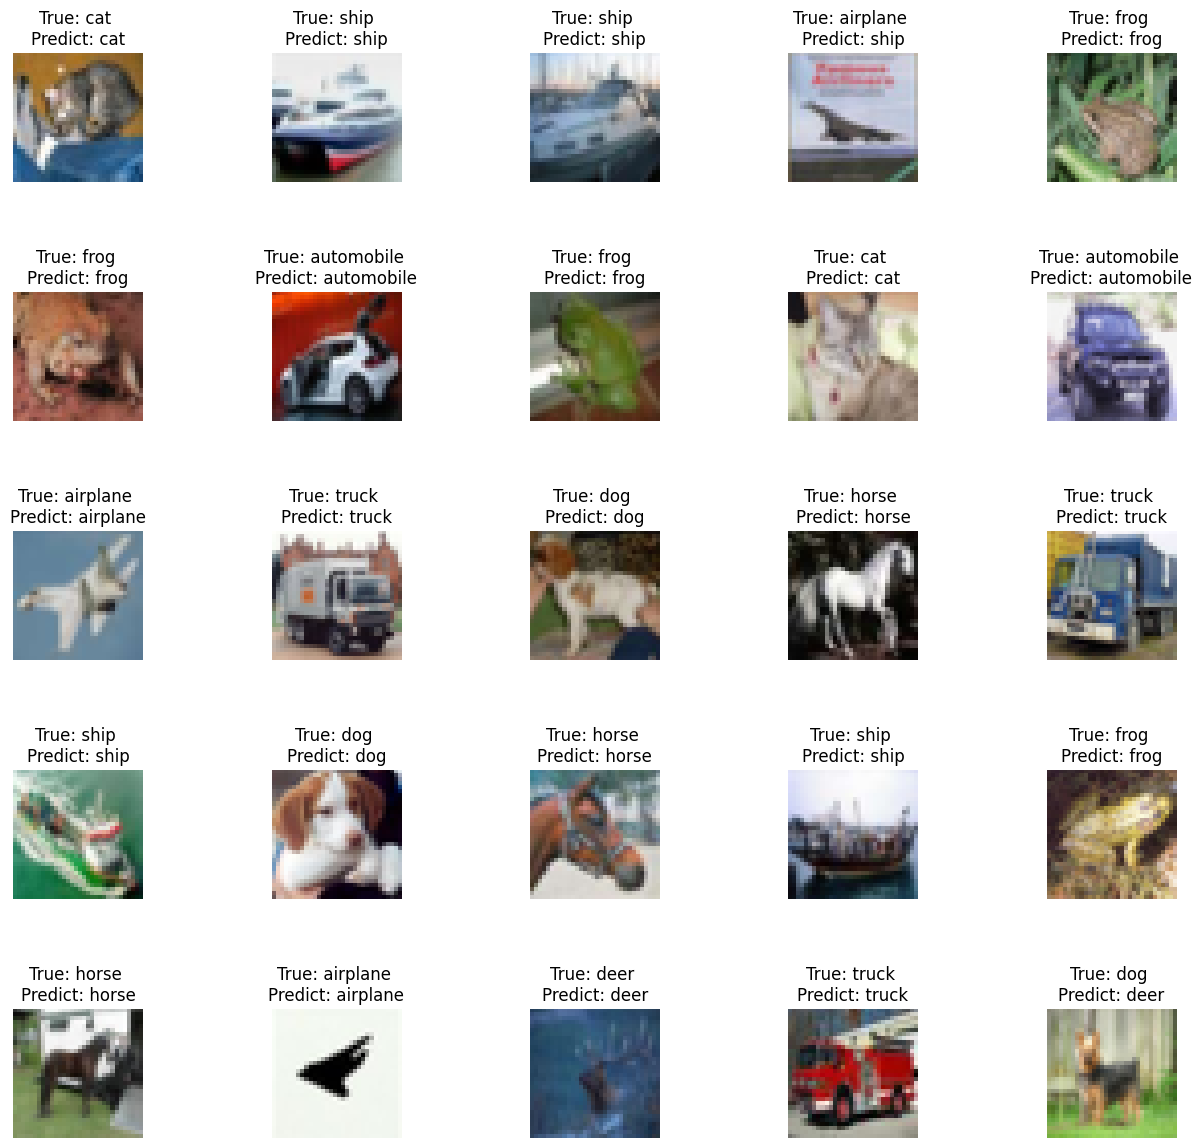

In [19]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(test_images[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[np.argmax(test_labels[i])], class_names[pred_labels[i]]))
    axes[i].axis("off")
    plt.subplots_adjust(wspace=1)

## Test result insights

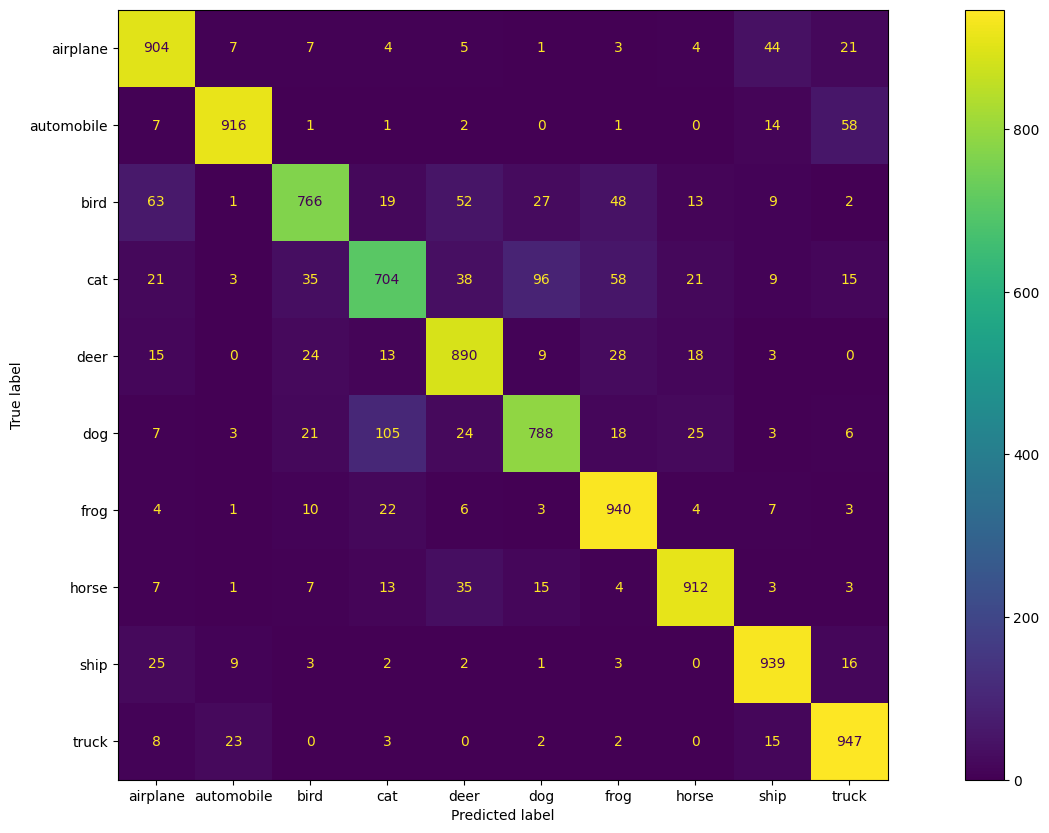

In [63]:
confusion_metrics = metrics.confusion_matrix(np.argmax(test_labels, axis=1), pred_labels)
display = metrics.ConfusionMatrixDisplay(confusion_metrics, display_labels=class_names)
fig, axes = plt.subplots(figsize=(20, 10))
display.plot(ax=axes)
plt.show()

In [68]:
print(metrics.classification_report(np.argmax(test_labels, axis=1), pred_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.85      0.90      0.88      1000
  automobile       0.95      0.92      0.93      1000
        bird       0.88      0.77      0.82      1000
         cat       0.79      0.70      0.75      1000
        deer       0.84      0.89      0.87      1000
         dog       0.84      0.79      0.81      1000
        frog       0.85      0.94      0.89      1000
       horse       0.91      0.91      0.91      1000
        ship       0.90      0.94      0.92      1000
       truck       0.88      0.95      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

